In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
import sys
import scanpy as sc
import anndata as ad
import logging
import numpy as np
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix
from scipy.io import mmread, mmwrite
import os 
import scipy.io as sio
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import scanpy as sc

import sys
import schema
from schema import SchemaQP

In [5]:
path = "/mnt/10_GSE201402_down"
cell_names = pd.read_csv(path+'/RNA/barcodes.tsv', sep = '\t', header=None, index_col=None)
cell_names.columns =  ['cell_ids']
X = csr_matrix(mmread(path+'/RNA/matrix.mtx').T)
gene_names = pd.read_csv(path+'/RNA/features.tsv', sep = '\t',  header=None, index_col=None)
gene_names.columns =  ['gene_ids']
adata_RNA = ad.AnnData(X, obs=pd.DataFrame(index=cell_names.cell_ids), var=pd.DataFrame(index = gene_names.gene_ids))
adata_RNA.var_names_make_unique()
sc.pp.filter_cells(adata_RNA, min_genes=10)
sc.pp.filter_genes(adata_RNA, min_cells=20)

# peak information
cell_names = pd.read_csv(path+'/ATAC/barcodes.tsv', sep = '\t', header=None, index_col=None)
cell_names.columns =  ['cell_ids']
X = csr_matrix(mmread(path+'/ATAC/matrix.mtx').T)
peak_name = pd.read_csv(path+'/ATAC/features.tsv',header=None,index_col=None)
peak_name.columns = ['peak_ids']
adata_ATAC  = ad.AnnData(X, obs=pd.DataFrame(index=cell_names.cell_ids), var=pd.DataFrame(index = peak_name.peak_ids))
sc.pp.filter_cells(adata_ATAC, min_genes=10)
sc.pp.filter_genes(adata_ATAC, min_cells=1)

adata_RNA.obs['data_type'] = 'RNA'
adata_ATAC.obs['data_type'] = 'ATAC'

In [ ]:
import sklearn
from sklearn.decomposition import TruncatedSVD
svd2 = sklearn.decomposition.TruncatedSVD(n_components= 50, random_state = 17)
H2 = svd2.fit_transform(adata_ATAC.X)

sqp99 = schema.SchemaQP(min_desired_corr=0.99, mode='affine', params= {"decomposition_model":"nmf",
                                                      "num_top_components":50,
                                                      "do_whiten": 0,
                                                      "dist_npairs": 5000000})
dz99 = sqp99.fit_transform(adata_RNA.X, [H2], ['feature_vector'], [1])

np.savetxt("/mnt/appealing/10_GSE201402_down/"+"Schema.csv", dz99, delimiter=',')

In [1]:
import sklearn
print(sklearn.__version__)

0.24.2


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


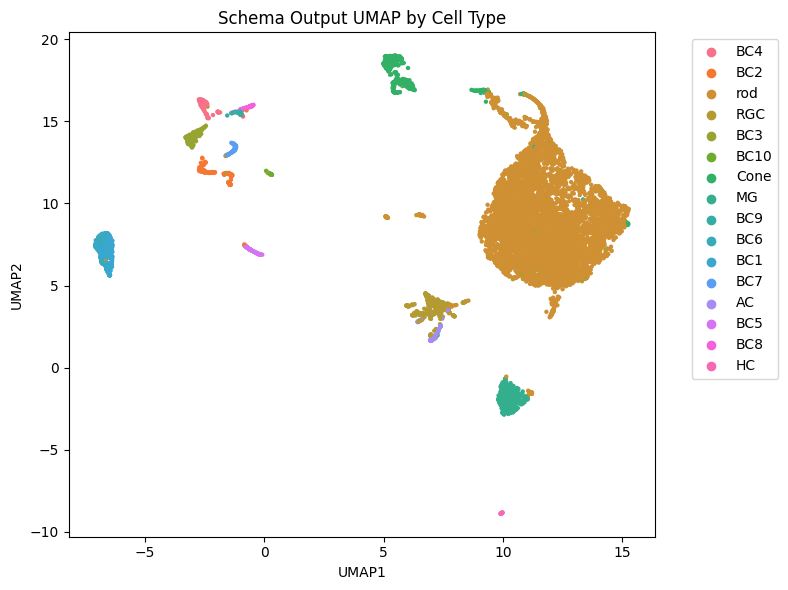

In [8]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
dz99 = np.loadtxt("/mnt/appealing/10_GSE201402_down/Schema.csv", delimiter=",")
metadata = pd.read_csv("/mnt/10_GSE201402_down/metadata.csv")
assert dz99.shape[0] == metadata.shape[0], "Mismatch between embedding and metadata!"
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(dz99)
plot_df = pd.DataFrame(embedding_2d, columns=["UMAP1", "UMAP2"])
plot_df["celltype"] = metadata["celltype"].values
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="UMAP1", y="UMAP2", hue="celltype", s=10, linewidth=0)
plt.title("Schema Output UMAP by Cell Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()